In [442]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # @ 100%, fits width of screen

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import StandardScaler 

In [561]:
# User input parameters – are you testing? If not, then make predictions
# Predict closing price (higher or lower) over the next x days
# (to be wrapped in an API in the future)
days_to_predict = 3
testing = True


# Train with data prior to test_day and test with data after
test_split_date = "2017-07-01"
split_date = datetime.date.today()

if testing == True:
    split_date = test_split_date
    print('Testing model implementation: \n    Will split Train/Test data on the date:', split_date)
    


Testing model implementation: 
    Will split Train/Test data on the date: 2017-07-01


In [562]:
# Data preprocessing

# Read in raw data
btc_info = pd.read_csv("BCHARTS-HITBTCUSD.csv", index_col = 0)

block_info = pd.read_csv("BlockchainData.csv", index_col = 0)

# Get data from late 2016 to the present day
btc_info = btc_info.sort_index(ascending = True)["2016-11-08":str(datetime.date.today())]
block_info = block_info["2016-11-08":str(datetime.date.today())]

# Add new metric 'Volatility' to btc_info, remove extraneous information
btc_info["Volatility"] = abs(btc_info["High"] - btc_info["Low"])/btc_info["Open"]
btc_info.drop(labels = ["Open", "High", "Low", "Volume (Currency)", "Weighted Price"], axis = 1, inplace = True)

# Drop extraneous information from block_info
block_info.drop(labels = ["market-price", "total-bitcoins", "market-cap", "blocks-size", "n-orphaned-blocks", "difficulty", "miners-revenue", "transaction-fees-usd","n-transactions-total", "n-transactions-excluding-chains-longer-than-100", "estimated-transaction-volume-usd"], axis = 1, inplace = True)

# Merge BTC price and blockchain info tables
all_data = btc_info.merge(block_info, how = "left", left_index = True, right_index = True)
closing_prices =  btc_info[:]["Close"]
all_data.head()

,Close,Volume (BTC),Volatility,avg-block-size,n-transactions,trade-volume,n-transactions-per-block,median-confirmation-time,hash-rate,transaction-fees,cost-per-transaction-percent,cost-per-transaction,n-unique-addresses,n-transactions-excluding-popular,output-volume,estimated-transaction-volume
Date,,,,,,,,,,,,,,,,
2016-11-08,709.55,30.88,0.022615,0.866266,296060.0,2.172039e+07,1751.834320,12.150000,2.139073e+06,89.255359,0.747867,5.293851,503015.0,265464.0,3.497745e+06,294404.747031
2016-11-09,721.66,24.31,0.049683,0.891799,270095.0,4.030893e+07,1837.380952,9.300000,1.860614e+06,83.731986,0.480759,5.153777,474975.0,266380.0,2.694658e+06,399624.834572
2016-11-10,714.64,19.30,0.018997,0.804537,271374.0,1.834551e+07,1615.321429,11.475000,2.126416e+06,82.292867,0.831528,5.748729,474281.0,250080.0,1.759909e+06,262443.613501
2016-11-11,712.38,21.62,0.012048,0.754813,254619.0,1.400861e+07,1562.079755,6.966667,2.063130e+06,72.744025,0.988747,5.931863,444226.0,224529.0,1.395607e+06,213426.022201
2016-11-12,701.28,10.41,0.021474,0.710403,228886.0,1.356855e+07,1362.416667,6.466667,2.126416e+06,65.895361,1.276111,6.656963,450559.0,216563.0,9.500699e+05,169726.192397


In [563]:
# Data normalization 

from sklearn.preprocessing import MinMaxScaler, minmax_scale
scaler = MinMaxScaler(copy = True, feature_range = (-1, 1))

# Fit all data to scaler
scaler.fit(all_data)

# Normalize later
all_data_scaled = all_data

# Pick an arbitrary date at which to cut the model into training / testing datasets
split_date = '2017-07-01'

# Split data
train_data, test_data = all_data_scaled.loc['2016-11-09':split_date], all_data_scaled.loc[split_date:]

# Pick a window length (length of sliding short term memory) for the model
window_len = 2

# Split the testing and training data into rolling bins of size window_length
# Normalize the data to the first value in the column
training_inputs = []
for i in range(len(train_data) - window_len):
    temp_set = train_data[i:(i + window_len)].copy() / train_data.iloc[0]
    training_inputs.append(temp_set)


test_inputs = []
for i in range(len(test_set) - window_len):
    temp_set = test_set[i:(i + window_len)].copy() / train_data.iloc[0]
    test_inputs.append(temp_set)

In [564]:
train_data.head()

,Close,Volume (BTC),Volatility,avg-block-size,n-transactions,trade-volume,n-transactions-per-block,median-confirmation-time,hash-rate,transaction-fees,cost-per-transaction-percent,cost-per-transaction,n-unique-addresses,n-transactions-excluding-popular,output-volume,estimated-transaction-volume
Date,,,,,,,,,,,,,,,,
2016-11-09,721.66,24.31,0.049683,0.891799,270095.0,4.030893e+07,1837.380952,9.300000,1.860614e+06,83.731986,0.480759,5.153777,474975.0,266380.0,2.694658e+06,399624.834572
2016-11-10,714.64,19.30,0.018997,0.804537,271374.0,1.834551e+07,1615.321429,11.475000,2.126416e+06,82.292867,0.831528,5.748729,474281.0,250080.0,1.759909e+06,262443.613501
2016-11-11,712.38,21.62,0.012048,0.754813,254619.0,1.400861e+07,1562.079755,6.966667,2.063130e+06,72.744025,0.988747,5.931863,444226.0,224529.0,1.395607e+06,213426.022201
2016-11-12,701.28,10.41,0.021474,0.710403,228886.0,1.356855e+07,1362.416667,6.466667,2.126416e+06,65.895361,1.276111,6.656963,450559.0,216563.0,9.500699e+05,169726.192397
2016-11-13,698.01,19.90,0.024626,0.773230,221328.0,1.990067e+07,1547.748252,8.333333,1.809985e+06,63.154926,1.044009,5.883469,411263.0,266080.0,1.131284e+06,177264.208361


In [565]:
training_inputs[0]

,Close,Volume (BTC),Volatility,avg-block-size,n-transactions,trade-volume,n-transactions-per-block,median-confirmation-time,hash-rate,transaction-fees,cost-per-transaction-percent,cost-per-transaction,n-unique-addresses,n-transactions-excluding-popular,output-volume,estimated-transaction-volume
Date,,,,,,,,,,,,,,,,
2016-11-09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.00000,1.000000
2016-11-10,0.990272,0.793912,0.382363,0.902151,1.004735,0.455123,0.879143,1.233871,1.142857,0.982813,1.729616,1.11544,0.998539,0.938809,0.65311,0.656725


In [566]:
# Convert to numpy for speed in future calculations
training_inputs = [np.array(training_input) for training_input in training_inputs]
training_inputs = np.array(training_inputs)

test_inputs = [np.array(test_inputs) for test_inputs in test_inputs]
test_inputs = np.array(test_inputs)

In [567]:
# Karas backend to build model
# Long Short Term Memory
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func = "linear", dropout = 0.25, loss = "mae", optimizer = "adam"):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units = output_size))
    model.add(Activation(activ_func))
    model.compile(loss = loss, optimizer = optimizer)
    return model

In [568]:
# Constant random seed for testing purposes
np.random.seed(4)

# Initialize model; output size is 1 (price), number of hidden layers = neurons
btc_model = build_model(training_inputs, output_size = 1, neurons = 15)

# model output is next price normalised to window_length previous closing price
training_outputs = (train_data['Close'][window_len:].values / train_data['Close'][:-window_len].values) - 1

# train model on data; btc_history = training error array
btc_history = btc_model.fit(training_inputs, training_outputs, epochs = 30, batch_size = 1, verbose = 2, shuffle = True)

Epoch 1/30
 - 4s - loss: 0.1157
Epoch 2/30
 - 1s - loss: 0.0602
Epoch 3/30
 - 1s - loss: 0.0491
Epoch 4/30
 - 1s - loss: 0.0449
Epoch 5/30
 - 1s - loss: 0.0437
Epoch 6/30
 - 1s - loss: 0.0411
Epoch 7/30
 - 1s - loss: 0.0414
Epoch 8/30
 - 1s - loss: 0.0400
Epoch 9/30
 - 1s - loss: 0.0397
Epoch 10/30
 - 1s - loss: 0.0396
Epoch 11/30
 - 1s - loss: 0.0403
Epoch 12/30
 - 1s - loss: 0.0394
Epoch 13/30
 - 1s - loss: 0.0396
Epoch 14/30
 - 1s - loss: 0.0399
Epoch 15/30
 - 1s - loss: 0.0393
Epoch 16/30
 - 1s - loss: 0.0397
Epoch 17/30
 - 1s - loss: 0.0378
Epoch 18/30
 - 1s - loss: 0.0394
Epoch 19/30
 - 1s - loss: 0.0369
Epoch 20/30
 - 1s - loss: 0.0381
Epoch 21/30
 - 1s - loss: 0.0378
Epoch 22/30
 - 1s - loss: 0.0388
Epoch 23/30
 - 1s - loss: 0.0395
Epoch 24/30
 - 1s - loss: 0.0382
Epoch 25/30
 - 1s - loss: 0.0370
Epoch 26/30
 - 1s - loss: 0.0388
Epoch 27/30
 - 1s - loss: 0.0375
Epoch 28/30
 - 1s - loss: 0.0373
Epoch 29/30
 - 1s - loss: 0.0369
Epoch 30/30
 - 1s - loss: 0.0371


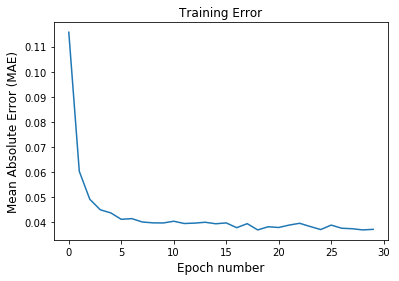

In [569]:
# Plot training error of model

fig, ax1 = plt.subplots(1,1)

ax1.plot(btc_history.epoch, btc_history.history['loss'])
ax1.set_title('Training Error')
ax1.set_ylabel('Mean Absolute Error (MAE)', fontsize = 12)    
ax1.set_xlabel('Epoch number', fontsize = 12)
plt.show()

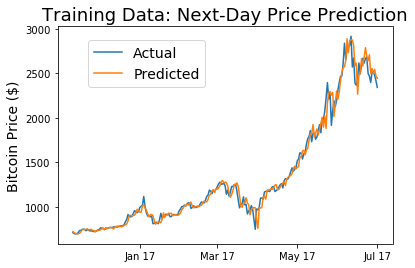

In [570]:
# need to reformat this
fig1, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2016, 2018) for j in [1,3,5, 7]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %y')  for i in range(2016,2018) for j in [1,3,5,7]])


ax1.plot(train_data.index.values[window_len:].astype(datetime.datetime), train_data['Close'][window_len:], label = 'Actual')
ax1.plot(train_data.index.values[window_len:].astype(datetime.datetime), ((np.transpose(btc_model.predict(training_inputs)) + 1) * train_data['Close'].values[:-window_len])[0], label = 'Predicted')

ax1.set_title('Training Data: Next-Day Price Prediction', fontsize = 18)
ax1.set_ylabel('Bitcoin Price ($)', fontsize = 14)
ax1.legend(bbox_to_anchor = (0.05, 1), loc = 2, borderaxespad = 1., prop = {'size': 14})



plt.show()
plt.gcf().clear()

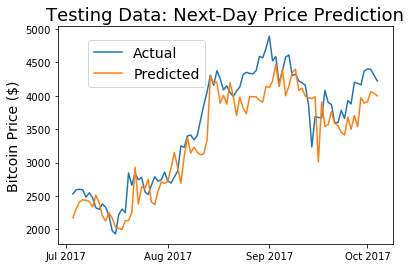

In [571]:
# need to reformat this
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2016, 2018) for j in [7,8,9,10,11]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2016, 2018) for j in [7,8,9,10,11]])


ax1.plot(test_data.index.values[window_len:].astype(datetime.datetime), test_data['Close'][window_len:], label = 'Actual')
ax1.plot(test_data.index.values[window_len:].astype(datetime.datetime), ((np.transpose(btc_model.predict(test_inputs)) + 1) * test_data['Close'].values[:-window_len])[0], label = 'Predicted')

ax1.set_title('Testing Data: Next-Day Price Prediction', fontsize = 18)
ax1.set_ylabel('Bitcoin Price ($)', fontsize = 14)
ax1.legend(bbox_to_anchor = (0.05, 1), loc = 2, borderaxespad = 1., prop = {'size': 14})


plt.show()
plt.gcf().clear()